# Estimating transforms from data

It is often necessary to estimate transformations between rigid bodies that are not explicitly known. This happens for example when the motion of the same rigid body is measured by different tracking systems that represent their data in different world frames.

<div class="alert alert-info">
Note
    
The following examples require the `matplotlib` library.
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rigid_body_motion as rbm

plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
rbm.register_frame("world")

## Shortest arc rotation

Let's assume we have two vectors $v_1$ and $v_2$:

In [3]:
v1 = (1, 0, 0)
v2 = (np.sqrt(2) / 2, np.sqrt(2) / 2, 0)

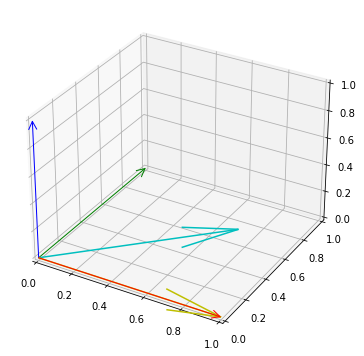

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

rbm.plot.reference_frame("world", ax=ax)
rbm.plot.vectors(v1, ax=ax, color="y")
rbm.plot.vectors(v2, ax=ax, color="c")

fig.tight_layout()

The quaternion $r$ that rotates $v_1$ in the same direction as $v_2$, i.e., that satisfies:

$$\frac{v_2}{\|v_2\|} = \frac{\operatorname{rot}(r, v_1)}{\|v_1\|}$$

can be computed with the [shortest_arc_rotation()](_generated/rigid_body_motion.shortest_arc_rotation.rst) method:

In [5]:
rbm.shortest_arc_rotation(v1, v2)

array([0.92387953, 0.        , 0.        , 0.38268343])

The method also works with arrays of vectors. Let's first construct an array of progressive rotations around the yaw axis with the [from_euler_angles()](_generated/rigid_body_motion.from_euler_angles.rst) method:

In [6]:
r = rbm.from_euler_angles(yaw=np.linspace(0, np.pi / 8, 10))

Now we can rotate $v_2$ with $r$. Because we rotate a single vector with multiple quaternions we have to specify `one_to_one=False`:

In [7]:
v2_arr = rbm.rotate_vectors(r, v2, one_to_one=False)

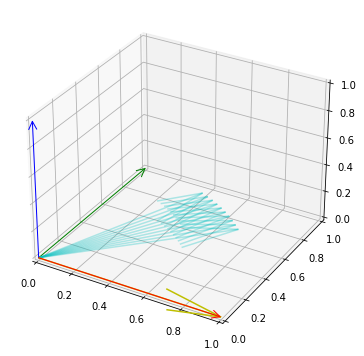

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

rbm.plot.reference_frame("world", ax=ax)
rbm.plot.vectors(v1, ax=ax, color="y")
rbm.plot.vectors(v2_arr, ax=ax, color="c", alpha=0.3)

fig.tight_layout()

[shortest_arc_rotation()](_generated/rigid_body_motion.shortest_arc_rotation.rst) now returns an array of quaternions:

In [9]:
rbm.shortest_arc_rotation(v1, v2_arr)

array([[0.92387953, 0.        , 0.        , 0.38268343],
       [0.91531148, 0.        , 0.        , 0.40274669],
       [0.90630779, 0.        , 0.        , 0.42261826],
       [0.89687274, 0.        , 0.        , 0.44228869],
       [0.88701083, 0.        , 0.        , 0.46174861],
       [0.87672676, 0.        , 0.        , 0.48098877],
       [0.8660254 , 0.        , 0.        , 0.5       ],
       [0.85491187, 0.        , 0.        , 0.51877326],
       [0.84339145, 0.        , 0.        , 0.53729961],
       [0.83146961, 0.        , 0.        , 0.55557023]])

## Best fit rotation

In a different scenario, we might have two vectors that are offset by a fixed rotation and are rotating in space:

In [10]:
v1_arr = rbm.rotate_vectors(r, v1, one_to_one=False)

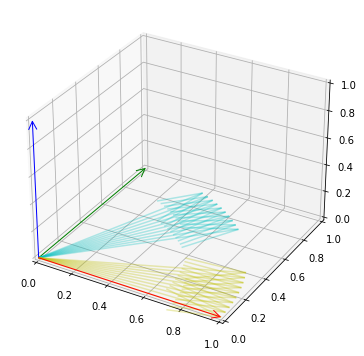

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

rbm.plot.reference_frame("world", ax=ax)
rbm.plot.vectors(v1_arr, ax=ax, color="y", alpha=0.3)
rbm.plot.vectors(v2_arr, ax=ax, color="c", alpha=0.3)

fig.tight_layout()

The rotation between the vectors can be found with a least-squares minimization:

$$\min_r \left\| v_2 - \operatorname{rot}(r, v_1) \right\|$$

This is implemented in the [best_fit_rotation()](_generated/rigid_body_motion.best_fit_rotation.rst) method:

In [12]:
rbm.best_fit_rotation(v1_arr, v2_arr)

array([ 0.92387953, -0.        , -0.        ,  0.38268343])

## Best fit transform

In yet another case, we might have two arrays of points (e.g. point clouds) with a fixed transform (rotation *and* translation) between them:

In [13]:
p1_arr = 0.1 * np.random.randn(100, 3)

In [14]:
t = np.array((1, 1, 0))
r = rbm.from_euler_angles(yaw=np.pi / 4)
p2_arr = rbm.rotate_vectors(r, p1_arr, one_to_one=False) + t

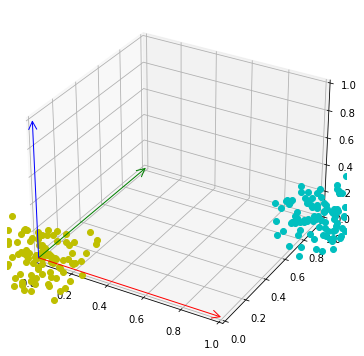

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

rbm.plot.reference_frame("world", ax=ax)
rbm.plot.points(p1_arr, ax=ax, fmt="yo")
rbm.plot.points(p2_arr, ax=ax, fmt="co")

fig.tight_layout()

To estimate this transform, we can minimize:

$$\min_r \left\| p_2 - (\operatorname{rot}(r, p_1) + t) \right\|$$

This algorithm (also called point set registration) is implemented in the [best_fit_transform()](_generated/rigid_body_motion.best_fit_transform.rst) method:

In [16]:
rbm.best_fit_transform(p1_arr, p2_arr)

(array([1.00000000e+00, 1.00000000e+00, 2.60208521e-18]),
 array([ 9.23879533e-01,  2.73751811e-17, -1.11022302e-16,  3.82683432e-01]))

## Iterative closest point

The above algorithm only works for known correspondences between points $p_1$ and $p_2$ (i.e., each point in `p1_arr` corresponds to the same index in `p2_arr`). This is not always the case - in fact, something like a point cloud from different laser scans of the same object might yield sets of completely different points. An approximate transform can still be found with the iterative closest point (ICP) algorithm. We can simulate the case of unknown correspondences by randomly permuting the second array:

In [17]:
rbm.iterative_closest_point(p1_arr, np.random.permutation(p2_arr))

(array([ 0.96242043,  0.95258535, -0.05130141]),
 array([0.36440883, 0.31892976, 0.35901466, 0.79787122]))

Note that there is a discrepancy in the estimated transform compared to the best fit transform. ICP usually yields better results with a larger number of points that have more spatial structure.